In [1]:
import numpy as np
from tensorflow import keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
data=pd.read_csv('E:/SEM-1/Smart Energy/Assignment1/Home1_Daily_data.csv')
df=data.loc[data['Date & Time']<'2014-12-01']

In [3]:
train_dates=pd.to_datetime(df['Date & Time'])

In [4]:
cols=list(data)[3:30]

In [5]:
df_for_training=data[cols].astype('float')

In [6]:
scaler=StandardScaler()

In [7]:
scaler=scaler.fit(df_for_training)

In [8]:
df_for_training_scaled=scaler.transform(df_for_training)

In [9]:
trainX=[]
trainY=[]

In [10]:
n_future=1
n_past=1

In [11]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future-1:i+n_future,0])

In [12]:
trainX, trainY=np.array(trainX),np.array(trainY)

In [13]:
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(364, 1, 27).
trainY shape==(364, 1).


In [14]:
model=Sequential()

In [15]:
model.add(LSTM(64,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))

In [16]:
model.add(LSTM(32,activation='relu',return_sequences=False))

In [17]:
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [18]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             23552     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 36,001
Trainable params: 36,001
Non-trainable params: 0
_________________________________________________________________


In [19]:
history=model.fit(trainX,trainY,epochs=10,batch_size=16,validation_split=0.1,verbose=1)

Epoch 1/10
21/21 [==============================] - 3s 29ms/step - loss: 0.9898 - val_loss: 0.8150
Epoch 2/10
21/21 [==============================] - 0s 5ms/step - loss: 0.9057 - val_loss: 0.7783
Epoch 3/10
21/21 [==============================] - 0s 5ms/step - loss: 0.7589 - val_loss: 0.6566
Epoch 4/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6039 - val_loss: 0.5358
Epoch 5/10
21/21 [==============================] - 0s 5ms/step - loss: 0.5265 - val_loss: 0.5431
Epoch 6/10
21/21 [==============================] - 0s 5ms/step - loss: 0.4651 - val_loss: 0.5200
Epoch 7/10
21/21 [==============================] - 0s 5ms/step - loss: 0.4417 - val_loss: 0.5095
Epoch 8/10
21/21 [==============================] - 0s 5ms/step - loss: 0.4513 - val_loss: 0.4931
Epoch 9/10
21/21 [==============================] - 0s 5ms/step - loss: 0.3965 - val_loss: 0.4895
Epoch 10/10
21/21 [==============================] - 0s 5ms/step - loss: 0.4033 - val_loss: 0.4901


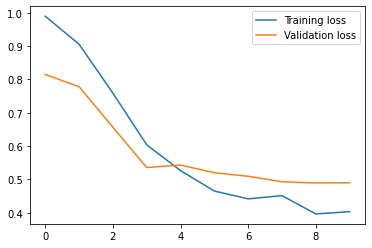

In [20]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.legend()

In [21]:
n_future=32

In [22]:
forecast_periods_dates=pd.date_range(list(train_dates)[-1],periods=n_future,freq='1d').tolist()

In [23]:
forecast=model.predict(trainX[-n_future:])

In [24]:
forecast_copies=np.repeat(forecast,df_for_training.shape[1],axis=-1)

In [25]:
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]

In [26]:
forecast_dates=[]

In [27]:
for time_i in forecast_periods_dates:
    forecast_dates.append(time_i.date())

In [28]:
df_forecast=pd.DataFrame({'Date & Time':np.array(forecast_dates),'House overall [kW]':y_pred_future})

In [29]:
df_forecast['Date & Time']=pd.to_datetime(df_forecast['Date & Time'])

In [30]:
#data=pd.read_csv('E:/SEM-1/Smart Energy/Assignment1/Home1_Daily_data.csv')
original=data[['Date & Time', 'House overall [kW]']]
original['Date & Time']=pd.to_datetime(original['Date & Time'])

C:\Users\bsaiv\AppData\Local\Temp\ipykernel_17984\2479359509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date & Time']=pd.to_datetime(original['Date & Time'])


In [31]:
original=original.loc[original['Date & Time']>='2014-11-30']

In [32]:
df_forecast.rename(columns = {'House overall [kW]' : 'House_overall_predicted'}, inplace = True)
original.rename(columns = {'House overall [kW]' : 'House_overall_Original'}, inplace = True)
final_dataset=df_forecast[['Date & Time','House_overall_predicted']].merge(original[['Date & Time','House_overall_Original']], on='Date & Time', how='left')
final_dataset

C:\Users\bsaiv\AppData\Local\Temp\ipykernel_17984\2722864905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original.rename(columns = {'House overall [kW]' : 'House_overall_Original'}, inplace = True)


,Date & Time,House_overall_predicted,House_overall_Original
0,2014-11-30,41.469246,24.779477
1,2014-12-01,34.851669,22.193308
2,2014-12-02,31.546305,41.024441
3,2014-12-03,39.532051,48.752172
4,2014-12-04,44.359932,43.555867
5,2014-12-05,40.543282,43.868534
6,2014-12-06,43.154083,46.880163
7,2014-12-07,50.537746,42.033757
8,2014-12-08,39.728806,51.628752
9,2014-12-09,53.183922,51.055545


C:\Users\bsaiv\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\bsaiv\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Date & Time', ylabel='House_overall_Original'>

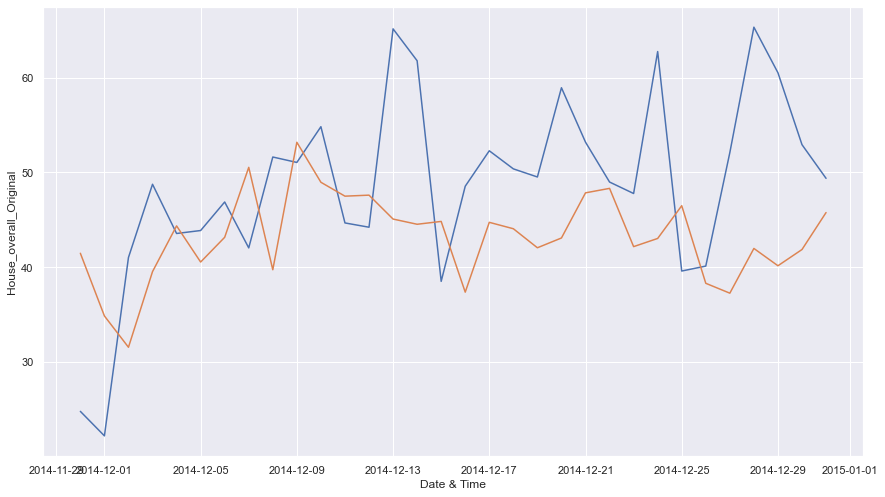

In [33]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.lineplot(original['Date & Time'],original['House_overall_Original'])
sns.lineplot(df_forecast['Date & Time'],df_forecast['House_overall_predicted'])

In [34]:
import numpy as np
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
rmse = sqrt(mean_squared_error(original['House_overall_Original'], df_forecast['House_overall_predicted'])) 
MAPE = mape(original['House_overall_Original'], df_forecast['House_overall_predicted'])
mae = mean_absolute_error(original['House_overall_Original'], df_forecast['House_overall_predicted'])
results = pd.DataFrame({'Method':['Multivariate time series forecasting using LSTM'], 'MAPE': [MAPE], 'RMSE': [rmse], 'MAE': [mae]})
results = results[['Method', 'RMSE', 'MAPE', 'MAE']]
results

,Method,RMSE,MAPE,MAE
0,Multivariate time series forecasting using LSTM,11.178442,19.555099,9.245983
